In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
plt.rcParams.update({'font.size': 16, 'lines.markersize': 8})
cmap = get_cmap('tab10').colors


In [2]:
def loadhist(reduced_filename):
    '''
    Load histogram data from file at path 'data/<reduced_filename>_hist'
    Returns two arrays:
    - bins: the rightmost bin edges excluding the last bin
    - counts: the counts in each bin
    '''
    filename = 'data/' + reduced_filename + '_hist'
    conv = lambda s: float(s.decode().replace(',','.')) # Converter function for np.loadtxt
    data = np.loadtxt(filename, delimiter=";", converters=conv)
    return data[:,0], data[:,1]

## Channel-Energy-Calibration wirh Na22

[-0.18976808388859584, 0.3133757006126222, 0.20342883249986357, -0.30478183693992356, 0.29422321843513616]


array([0.16228746, 1.51004809])

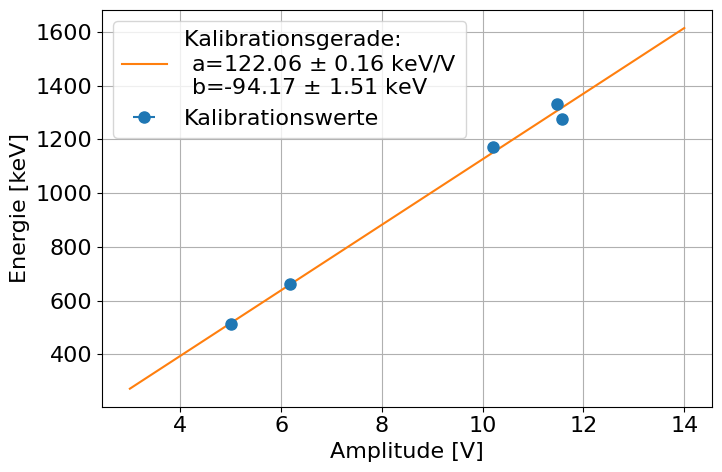

In [3]:
# Calibration behind the scenes -> func calibrate() and plots
def gauss(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))
# NATRIUM
b, c = loadhist('1_3_Na')
width = 0.01 # The width of each bin in the histogram
m_511 = (b>4) & (b<6)
m_1275 = (b>10.5) & (b<12.5)
popt_511, pcov_511 = curve_fit(gauss, b[m_511], c[m_511], p0=[1e3, 1, 1])
popt_1275, pcov_1275 = curve_fit(gauss, b[m_1275], c[m_1275], p0=[1e2, 10, 1])
# CAESIUM
b, c = loadhist('1_3_Cs')
m_662 = (b>5) & (b<8)
popt_662, pcov_662 = curve_fit(gauss, b[m_662], c[m_662], p0=[1e3, 6, 1])
# COBALT
b, c = loadhist('1_3_Co')
m_1173 = (b>9.6) & (b<10.9)
m_1332 = (b>11) & (b<12.3)
popt_1173, pcov_1173 = curve_fit(gauss, b[m_1173], c[m_1173], p0=[1e3, 10, 1])
popt_1332, pcov_1332 = curve_fit(gauss, b[m_1332], c[m_1332], p0=[1e3, 10, 1])

mus = np.array([popt_511[1], popt_1275[1], popt_662[1], popt_1173[1], popt_1332[1]])
err_mus = np.array([np.sqrt(pcov_511[1,1]), np.sqrt(pcov_1275[1,1]), np.sqrt(pcov_662[1,1]), np.sqrt(pcov_1173[1,1]), np.sqrt(pcov_1332[1,1])])
energies = np.array([511, 1275, 662, 1173, 1332])
(cal_slope, cal_intersect), pcov = curve_fit(lambda x, m, t: m*x + t, mus, energies, p0=[1,0], absolute_sigma=True)

def calibrate(x, m=cal_slope, t=cal_intersect):
    return m*x + t

fig,ax=plt.subplots(figsize=(7.5,5))
ax.errorbar(mus, energies, None, err_mus, 'o', label='Kalibrationswerte')
x = np.linspace(3,14,2)
ax.plot(x, calibrate(x), label=f'Kalibrationsgerade: \n a={cal_slope :.2f} $\pm$ {pcov[0,0]**0.5:.2f} keV/V \n b={cal_intersect :.2f} $\pm$ {pcov[1,1]**0.5:.2f} keV')
ax.set(xlabel='Amplitude [V]', ylabel='Energie [keV]')
ax.legend()
ax.grid()
fig.tight_layout()
plt.savefig('plots/sz_calibration.pdf', bbox_inches='tight')
print([popt_511[2], popt_1275[2], popt_662[2], popt_1173[2], popt_1332[2]])
np.sqrt(np.diag(pcov))#

## Energy Resolution

Na22 511 keV: 140363.10395314786
Na22 1275 keV: 36951.68374816984
[1652.05678138  660.69732547  -24.83003872] [[2.84134375e+01 1.12949709e-07 2.84700900e-01]
 [1.12949709e-07 8.55805646e-03 1.70013864e-09]
 [2.84700900e-01 1.70013864e-09 8.55805651e-03]]
Cs137 662 keV: 84749.63396778915
Co60 1173 keV: 49528.550512445094
Co60 1332 keV: 39310.3953147877
[0.00024391 0.00033195 0.00032995 0.00095839 0.00035828]
Mittlere Energieauflösung: 9.313685937900658 +/- 0.015084484991864752 %
[0.11297022 0.07525158 0.08849782 0.09426554 0.07648998] [0.00024391 0.00033195 0.00032995 0.00095839 0.00035828]


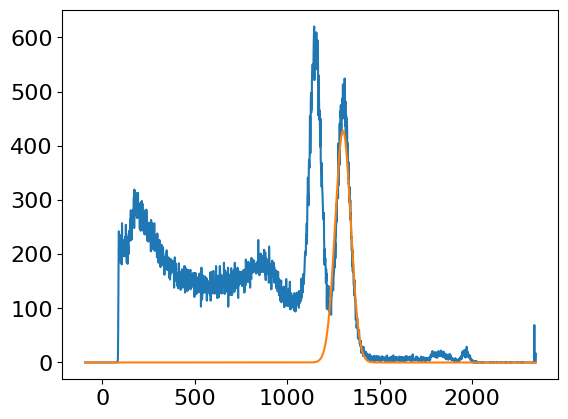

In [4]:
# Bins are the same for all three histograms
bins, c_na = loadhist('1_3_Na')
_ , c_cs = loadhist('1_3_Cs')
_ , c_co = loadhist('1_3_Co')
bins = calibrate(bins) # Do channel-energy-calibration on the bins
width = calibrate(0.01, cal_slope , 0) # And width

#Na22. Format: [[a1, mu1, sigma1], [std(a1), std(mu1), std(sigma1)], 
#               [a2, mu2, sigma2], [std(a2), std(mu2), std(sigma2)]]
na22 = []
m1 = (bins>300) & (bins<700)
m2 = (bins>1100) & (bins<1500)
popt1, pcov1 = curve_fit(gauss, bins[m1], c_na[m1], p0=[1e3, 511, 1], sigma=np.sqrt(c_na[m1]), absolute_sigma=True)
popt2, pcov2 = curve_fit(gauss, bins[m2], c_na[m2], p0=[1e3, 1275, 1], sigma=np.sqrt(c_na[m2]), absolute_sigma=True)
na22.append([popt1, np.diag(pcov1)**0.5, popt2, np.diag(pcov2)**0.5])
na22 = np.array(na22).squeeze()
# Calculate and print the counts in the peaks for task 2.5
l_edge, r_edge = popt1[1]-np.abs(popt1[2]), popt1[1]+np.abs(popt1[2])
counts = np.sum(c_na[(bins>=l_edge) & (bins<=r_edge)])
print('Na22 511 keV:', counts/0.683)
l_edge, r_edge = popt2[1]-np.abs(popt2[2]), popt2[1]+np.abs(popt2[2])
counts = np.sum(c_na[(bins>=l_edge) & (bins<=r_edge)])
print('Na22 1275 keV:', counts/0.683)

#Cs137:
cs137 = []
m1 = (bins>500) & (bins<1000)
popt1, pcov1 = curve_fit(gauss, bins[m1], c_cs[m1], p0=[1e3, 500, 1])
cs137.append([popt1, np.diag(pcov1)**0.5])
cs137 = np.array(cs137).squeeze()
print(popt1, pcov1)

# Calculate and print the counts in the peaks for task 2.5
l_edge, r_edge = popt1[1]-np.abs(popt1[2]), popt1[1]+np.abs(popt1[2])
counts = np.sum(c_cs[(bins>=l_edge) & (bins<=r_edge)])
print('Cs137 662 keV:', counts/0.683)


#Co60:
co60 = []
m1 = (bins>1050) & (bins<1190)
m2 = (bins>1200) & (bins<1500)
popt1, pcov1 = curve_fit(gauss, bins[m1], c_co[m1], p0=[500, 1e3, 100], sigma=np.sqrt(c_co[m1]), absolute_sigma=True)
popt2, pcov2 = curve_fit(gauss, bins[m2], c_co[m2], p0=[500, 1200, 100], sigma=np.sqrt(c_co[m2]), absolute_sigma=True)
co60.append([popt1, np.diag(pcov1)**0.5, popt2, np.diag(pcov2)**0.5])
co60 = np.array(co60).squeeze()

plt.plot(bins, c_co, label='Cs137')
plt.plot(bins, gauss(bins, *popt2), label='Fit')
# Calculate and print the counts in the peaks for task 2.5
l_edge, r_edge = popt1[1]-np.abs(popt1[2]), popt1[1]+np.abs(popt1[2])
counts = np.sum(c_co[(bins>=l_edge) & (bins<=r_edge)])
print('Co60 1173 keV:', counts/0.683)
l_edge, r_edge = popt2[1]-np.abs(popt2[2]), popt2[1]+np.abs(popt2[2])
counts = np.sum(c_co[(bins>=l_edge) & (bins<=r_edge)])
print('Co60 1332 keV:', counts/0.683)


# Calc resolution:
fwhm = lambda sigma: 2*np.sqrt(2*np.log(2))*sigma
res_na22 = [fwhm(na22[0,2])/na22[0,1], fwhm(na22[2,2])/na22[2,1]]
res_cs137 = fwhm(cs137[0,2])/cs137[0,1]
res_co60 = [fwhm(co60[0,2])/co60[0,1], fwhm(co60[2,2])/co60[2,1]]
res = np.abs(np.array([*res_na22, res_cs137, *res_co60]))

def err_on_res(mu, sigma, errmu, errsigma):
    return np.sqrt((fwhm(errsigma)/mu)**2 + (fwhm(sigma)*errmu/mu**2)**2)
err_res_na22 = [err_on_res(na22[0,1], na22[0,2], na22[1,1], na22[1,2]), 
                err_on_res(na22[2,1], na22[2,2], na22[3,1], na22[3,2])]
err_res_cs137 = err_on_res(cs137[0,1], cs137[0,2], cs137[1,1], cs137[1,2])#
err_res_co60 = [err_on_res(co60[0,1], co60[0,2], co60[1,1], co60[1,2]),
                err_on_res(co60[2,1], co60[2,2], co60[3,1], co60[3,2])]
err_res = np.abs(np.array([*err_res_na22, err_res_cs137, *err_res_co60]))
print(err_res)
# Calc weighted mean and error on it:
mean = np.average(res, weights=err_res**-2)
err_mean = np.sqrt(1/np.sum(err_res**-2))
# plt.errorbar([511, 1275, 662, 1173, 1332], np.abs(res), err_res, None, 'o')
# plt.axhline(mean)
print('Mittlere Energieauflösung:',mean*100, '+/-', err_mean*100, '%')
print(res, err_res)

## Compton Edge

Compton-Kante bei: 462 +/- 15 keV


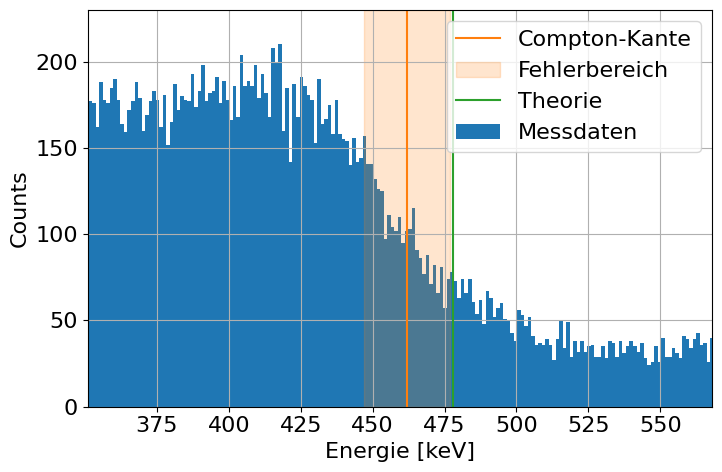

In [5]:
bins , c_cs = loadhist('1_3_Cs')
bins = calibrate(bins) # Do channel-energy-calibration on the bins
width = calibrate(0.01, cal_slope , 0) # And width
compton_mask = (bins>350) & (bins<570)

fig,ax=plt.subplots(figsize=(7.5,5))
ax.bar(bins[compton_mask],c_cs[compton_mask], width=width, color=cmap[0], label='Messdaten')
ax.axvline(462,color=cmap[1], label='Compton-Kante')
ax.fill_betweenx([0, 230], 447, 477, color=cmap[1], alpha=0.2, label='Fehlerbereich')
ax.axvline(478, color=cmap[2], label='Theorie')
ax.set(xlabel='Energie [keV]', ylabel='Counts', ylim=(0,230), xlim=(351,568))
ax.legend()
ax.grid()
fig.tight_layout()
plt.savefig('plots/sz_compton_edge.pdf', bbox_inches='tight')
print('Compton-Kante bei:', 462, '+/-', 15, 'keV')

## Dependency on distance

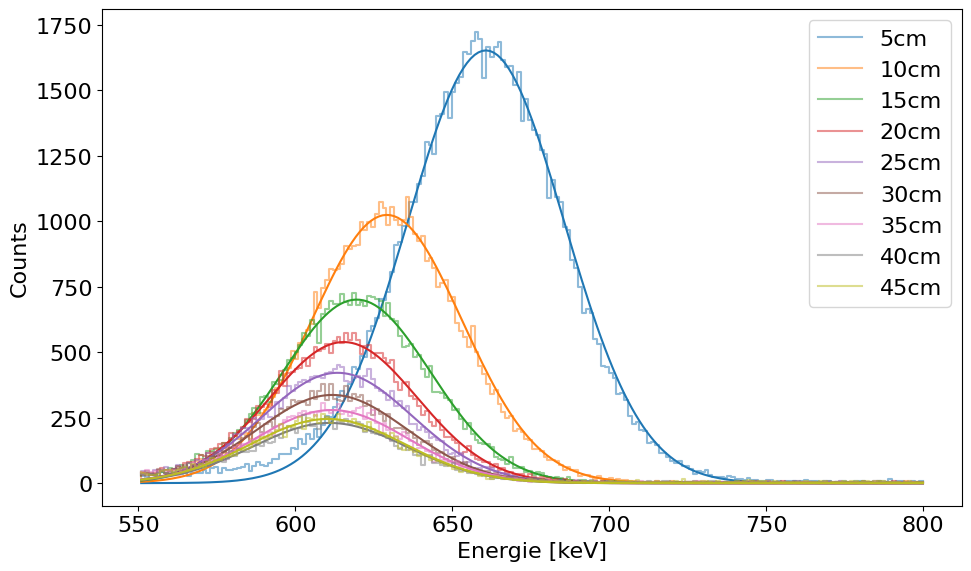

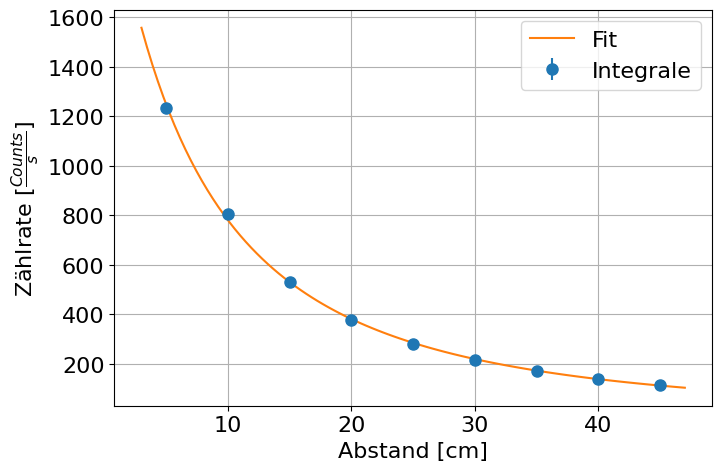

In [6]:
fnames = ['1_3_Cs', '1_4_10cm', '1_4_15cm', '1_4_20cm', '1_4_25cm', '1_4_30cm', '1_4_35cm', '1_4_40cm', '1_4_45cm']
width = calibrate(0.01, cal_slope , 0)

fig,ax=plt.subplots(figsize=(10,6))
integrals = []
for i,file in enumerate(fnames):
    #if i > 0: continue
    bins, c = loadhist(file)
    bins = calibrate(bins)
    fit_window = (bins>550) & (bins<750) 
    plot_window = (bins>550) & (bins<800)
    if i == 0:
        ax.step(bins[plot_window],c[plot_window], where='pre', color=cmap[i], label='5cm', alpha=0.5)
    else: 
        ax.step(bins[plot_window],c[plot_window], where='pre', color=cmap[i], label=file[4:], alpha=0.5)
    popt, pcov = curve_fit(gauss, bins[fit_window], c[fit_window], p0=[500, 600, 50])
    ax.plot(bins[plot_window], gauss(bins, *popt)[plot_window], color=cmap[i])
    x1, x2 = popt[1]-2*np.abs(popt[2]), popt[1]+2*np.abs(popt[2]) # 2 sigma interval
    # ax.plot(x1, gauss(x1, *popt), 'o', color=cmap[i])
    # ax.plot(x2, gauss(x2, *popt), 'o', color=cmap[i])
    #Integrate 2 sigma interval
    integral = np.sum(c[(bins>x1) & (bins<x2)])
    integrals.append(integral)
ax.set(xlabel='Energie [keV]', ylabel='Counts')

ax.legend()
fig.tight_layout()
plt.savefig('plots/sz_distance_histograms.pdf', bbox_inches='tight')

time = np.array([64814, 59481, 60563, 65600, 69336, 72770, 77640, 80130, 100985])*1e-3
distances = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45]) #cm
d_plot = np.linspace(3,47,100)
def inverse_quadratic(x, a, b, c):
    return a/(x-b)**2 + c
popt, pcov = curve_fit(inverse_quadratic, distances, integrals/time,p0= (0,0,1) , sigma=np.sqrt(integrals)/time, absolute_sigma=True)
fig,ax=plt.subplots(figsize=(7.5,5))
ax.errorbar(distances, integrals/time, np.sqrt(integrals)/time, None, 'o', label='Integrale')
ax.plot(d_plot, inverse_quadratic(d_plot, *popt), label='Fit')
ax.set(xlabel='Abstand [cm]', ylabel='Zählrate [$\\frac{Counts}{s}$]')
ax.legend()
ax.grid()
fig.tight_layout()
plt.savefig('plots/sz_distance_result.pdf', bbox_inches='tight')

## $\frac{\mu}{\rho}$

In [14]:
def lambert_beer(x, a, b):
    return a*np.exp(-b*x *density_copper)
raw_fnames = ['koll', '5mm', '10mm', '13mm', '18mm', '26mm', '56mm']
width = calibrate(0.01, cal_slope , 0)
copper_width = np.array([0,5,10,13,18,26,56])*0.1 #cm
density_copper = 8.96 #g/cm^3

Cs137 -> mu_red_662

Cs137 662 keV: 66994.14348462665


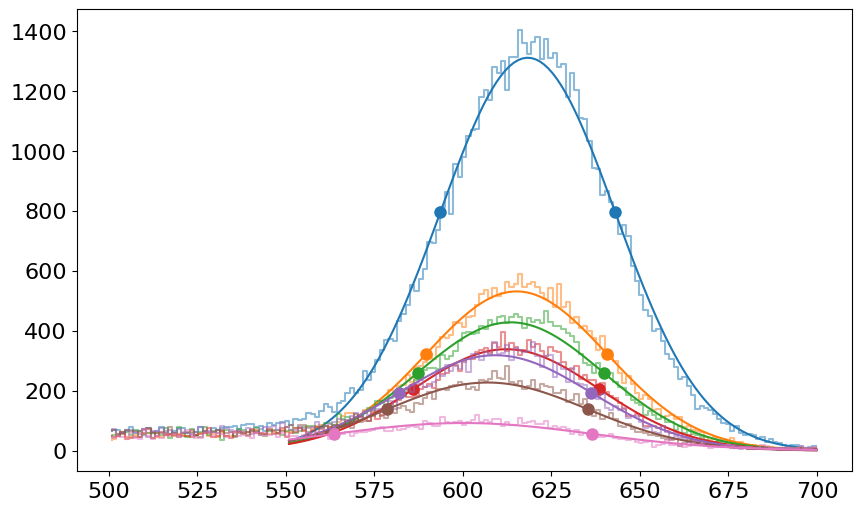

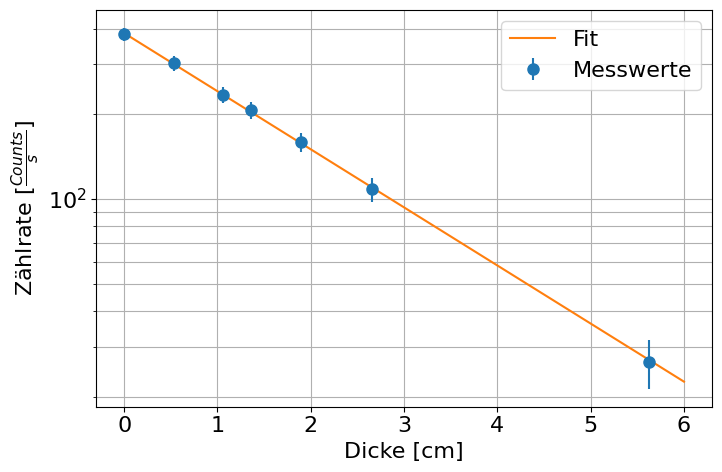

In [15]:
fnames = ['1_6_Cs_'+ rf for rf in raw_fnames]
meas_time = np.array([119706, 64462, 68669, 61275, 77219, 85613, 183608])*1e-3
fig,ax=plt.subplots(figsize=(10,6))
integrals = []
for i,file in enumerate(fnames):
    #if i < 2: continue
    bins, c = loadhist(file)
    bins = calibrate(bins)
    fit_window = (bins>550) & (bins<700)
    plot_window = (bins>500) & (bins<700)
    ax.step(bins[plot_window],c[plot_window], where='pre', color=cmap[i], label=file[4:], alpha=0.5)
    popt, pcov = curve_fit(gauss, bins[fit_window], c[fit_window], p0=[100, 600, 50], sigma=np.sqrt(c[fit_window]), absolute_sigma=True)
    ax.plot(bins[fit_window], gauss(bins, *popt)[fit_window], color=cmap[i])
    x1, x2 = popt[1]-np.abs(popt[2]), popt[1]+np.abs(popt[2]) # 1 sigma interval
    ax.plot(x1, gauss(x1, *popt), 'o', color=cmap[i])
    ax.plot(x2, gauss(x2, *popt), 'o', color=cmap[i])
    #Integrate 2 sigma interval
    integral = np.sum(c[(bins>=x1) & (bins<=x2)])
    integrals.append(integral)

integrals = np.array(integrals)
rate = integrals/meas_time
popt, pcov = curve_fit(lambert_beer, copper_width, rate, p0=(1,0.01), sigma=np.sqrt(rate), absolute_sigma=True)
mu_red_662 = np.array([popt[1], np.sqrt(pcov[1,1])])
fig, ax = plt.subplots(figsize=(7.5,5))
ax.errorbar(copper_width, rate,np.sqrt(rate), None, 'o' , label='Messwerte')
ax.plot(np.linspace(0,6,100), lambert_beer(np.linspace(0,6,100), *popt), label='Fit')
ax.set(xlabel='Dicke [cm]', ylabel='Zählrate [$\\frac{Counts}{s}$]', yscale='log')
ax.legend()
ax.grid(which='both')
fig.tight_layout()
plt.savefig('plots/sz_cu_mu662.pdf', bbox_inches='tight')
# Calc. the integral for task 2.5
print('Cs137 662 keV:', integrals[0]/0.683)

Cs137 662 keV for edge: 72367.49633967789


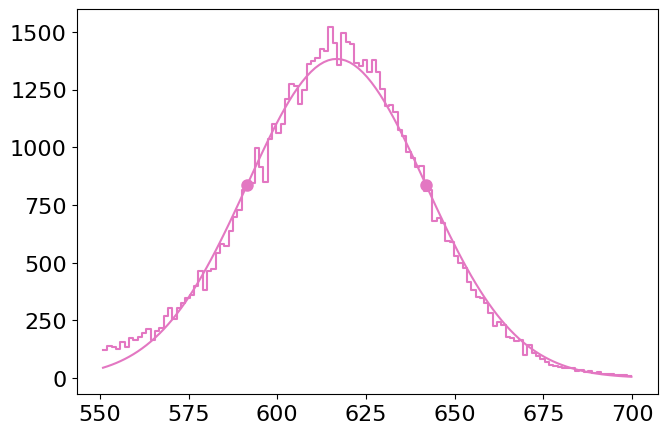

In [16]:
# Unrelated to this task: Calculate Cs integral for edge for task 2.5
b, c = loadhist('1_5_edge')
b = calibrate(b)
fit_window = (b>550) & (b<700)
fig,ax=plt.subplots(figsize=(7.5,5))
ax.step(bins[fit_window],c[fit_window], where='pre', color=cmap[i])
popt, pcov = curve_fit(gauss, bins[fit_window], c[fit_window], p0=[100, 600, 50], sigma=np.sqrt(c[fit_window]), absolute_sigma=True)
ax.plot(bins[fit_window], gauss(bins, *popt)[fit_window], color=cmap[i])
x1, x2 = popt[1]-np.abs(popt[2]), popt[1]+np.abs(popt[2]) # 1 sigma interval
ax.plot(x1, gauss(x1, *popt), 'o', color=cmap[i])
ax.plot(x2, gauss(x2, *popt), 'o', color=cmap[i])
#Integrate 2 sigma interval
integral = np.sum(c[(bins>=x1) & (bins<=x2)])
print('Cs137 662 keV for edge:', integral/0.683)

Co -> mu_red_1173

Cs137 1173 keV: 17745.24158125915


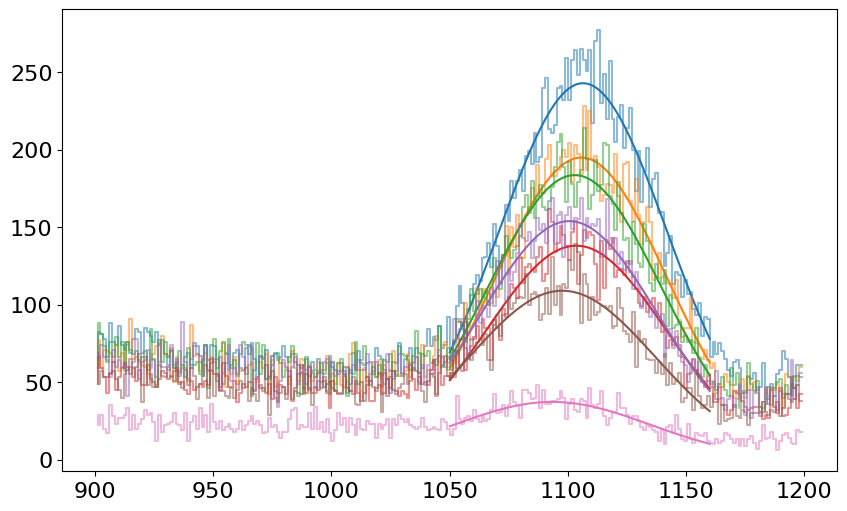

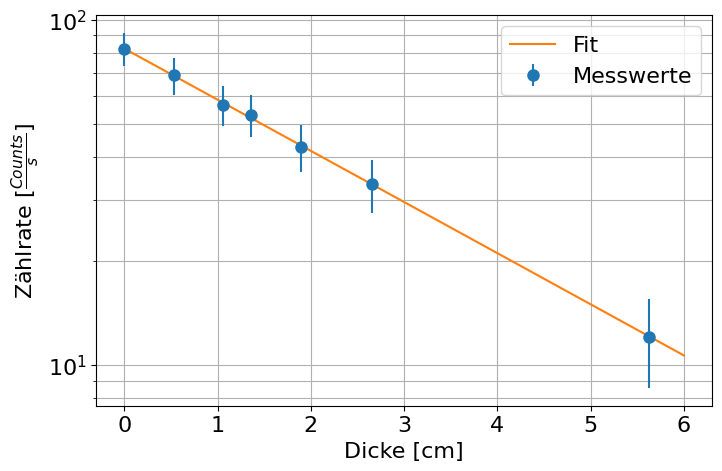

In [17]:
fnames = ['1_6_Co_'+ rf for rf in raw_fnames]
meas_time = np.array([147116, 145211, 167119, 138898, 191008 ,183274, 186061])*1e-3
fig,ax=plt.subplots(figsize=(10,6))
integrals = []
for i,file in enumerate(fnames):
    #if i > 2: continue
    bins, c = loadhist(file)
    bins = calibrate(bins)
    fit_window = (bins>1050) & (bins<1160)
    plot_window = (bins>900) & (bins<1200)
    ax.step(bins[plot_window],c[plot_window], where='pre', color=cmap[i], label=file[4:], alpha=0.5)
    popt, pcov = curve_fit(gauss, bins[fit_window], c[fit_window], p0=[100, 1100, 100], sigma=np.sqrt(c[fit_window]), absolute_sigma=True)
    ax.plot(bins[fit_window], gauss(bins, *popt)[fit_window], color=cmap[i])
    x1, x2 = popt[1]-np.abs(popt[2]), popt[1]+np.abs(popt[2]) # 2 sigma interval
    #ax.plot(x1, gauss(x1, *popt), 'o', color=cmap[i])
    #ax.plot(x2, gauss(x2, *popt), 'o', color=cmap[i])
    #Integrate 2 sigma interval
    integral = np.sum(c[(bins>=x1) & (bins<=x2)])
    integrals.append(integral)

integrals = np.array(integrals)
rate = integrals/meas_time
popt, pcov = curve_fit(lambert_beer, copper_width, rate, p0=(1,0.01), sigma=np.sqrt(rate), absolute_sigma=True)
mu_red_1173 = np.array([popt[1], np.sqrt(pcov[1,1])])
fig, ax = plt.subplots(figsize=(7.5,5))
ax.errorbar(copper_width, rate,np.sqrt(rate), None, 'o', label='Messwerte')
ax.plot(np.linspace(0,6,100), lambert_beer(np.linspace(0,6,100), *popt), label='Fit')
ax.set(xlabel='Dicke [cm]', ylabel='Zählrate [$\\frac{Counts}{s}$]', yscale='log')
ax.legend()
ax.grid(which='both')
fig.tight_layout()
plt.savefig('plots/sz_cu_mu1173.pdf', bbox_inches='tight')
# Calc. the integral for task 2.5
print('Cs137 1173 keV:', integrals[0]/0.683)

Co -> mu_red_1332

Co 1332 keV: 14793.557833089311


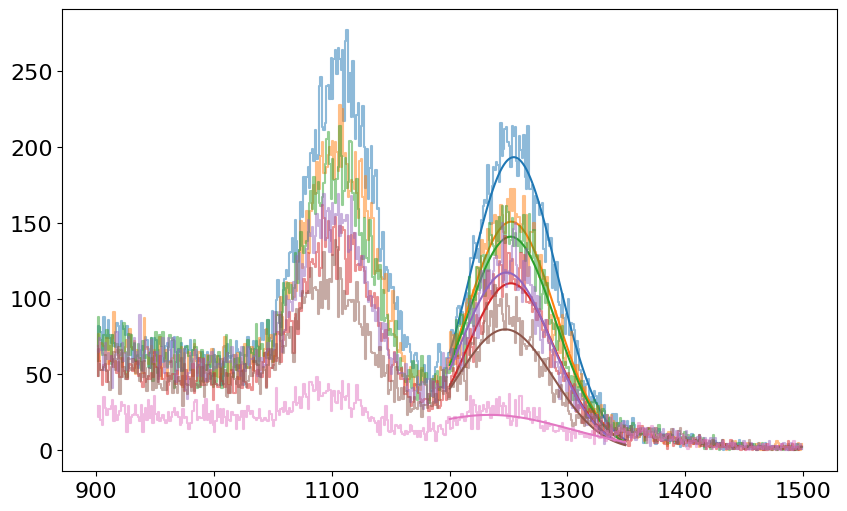

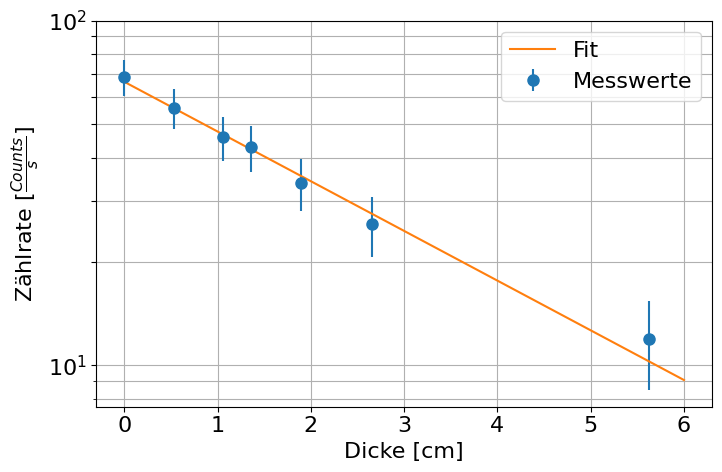

In [18]:
from matplotlib.pyplot import yscale


fnames = ['1_6_Co_'+ rf for rf in raw_fnames]
meas_time = np.array([147116, 145211, 167119, 138898, 191008 ,183274, 186061])*1e-3
fig,ax=plt.subplots(figsize=(10,6))
integrals = []
for i,file in enumerate(fnames):
    #if i > 2: continue
    bins, c = loadhist(file)
    bins = calibrate(bins)
    fit_window = (bins>1200) & (bins<1350)
    plot_window = (bins>900) & (bins<1500)
    ax.step(bins[plot_window],c[plot_window], where='pre', color=cmap[i], label=file[4:], alpha=0.5)
    popt, pcov = curve_fit(gauss, bins[fit_window], c[fit_window], p0=[100, 1100, 100], sigma=np.sqrt(c[fit_window]), absolute_sigma=True)
    ax.plot(bins[fit_window], gauss(bins, *popt)[fit_window], color=cmap[i])
    x1, x2 = popt[1]-np.abs(popt[2]), popt[1]+np.abs(popt[2]) # 2 sigma interval
    #ax.plot(x1, gauss(x1, *popt), 'o', color=cmap[i])
    #ax.plot(x2, gauss(x2, *popt), 'o', color=cmap[i])
    #Integrate 2 sigma interval
    integral = np.sum(c[(bins>=x1) & (bins<=x2)])
    integrals.append(integral)

integrals = np.array(integrals)
rate = integrals/meas_time
popt, pcov = curve_fit(lambert_beer, copper_width, rate, p0=(1,0.01), sigma=np.sqrt(rate), absolute_sigma=True)
mu_red_1332 = np.array([popt[1] , np.sqrt(pcov[1,1])])
fig, ax = plt.subplots(figsize=(7.5,5))
ax.errorbar(copper_width, rate,np.sqrt(rate), None, 'o', label='Messwerte')
ax.plot(np.linspace(0,6,100), lambert_beer(np.linspace(0,6,100), *popt), label='Fit')
ax.set(xlabel='Dicke [cm]', ylabel='Zählrate [$\\frac{Counts}{s}$]', yscale='log', yticks=[10,20,30,40,50,60,70,80,90,100])
ax.grid(which='both')
ax.legend()
fig.tight_layout()
plt.savefig('plots/sz_cu_mu1132.pdf', bbox_inches='tight')
# Calc. the integral for task 2.5
print('Co 1332 keV:', integrals[0]/0.683)


synopsis

array([0.00288433, 0.00508912, 0.00578116])

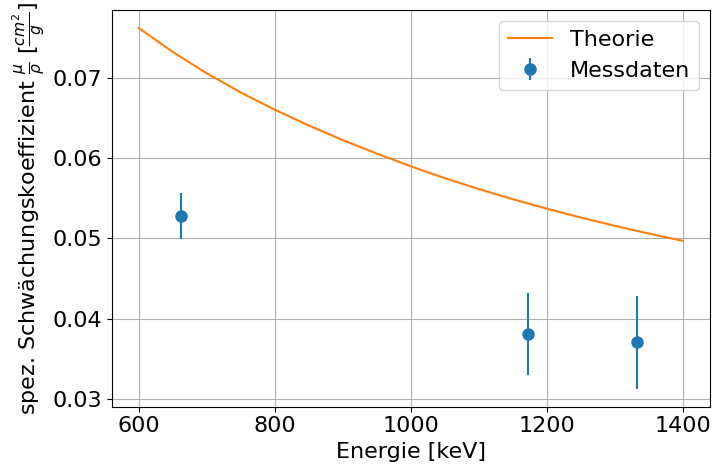

In [19]:
mus = np.array([mu_red_662[0], mu_red_1173[0], mu_red_1332[0]])
err_mus = np.array([mu_red_662[1], mu_red_1173[1], mu_red_1332[1]])
energy = np.array([662, 1173, 1332])
th_data = np.loadtxt('data/theory.txt', skiprows=3)
th_data = th_data[27:45]
fig,ax= plt.subplots(figsize=(7.5,5))
ax.errorbar(energy, mus, err_mus, None, 'o', label='Messdaten')
ax.plot(th_data[:,0]*1e3, th_data[:,2], label='Theorie')
ax.set(xlabel='Energie [keV]', ylabel='spez. Schwächungskoeffizient $\\frac{\mu}{\\rho}$ [$\\frac{cm^2}{g}$]')
ax.legend()
ax.grid()
fig.tight_layout()
plt.savefig('plots/sz_cu_mu_all.pdf', bbox_inches='tight')
err_mus

## Z-Dependency

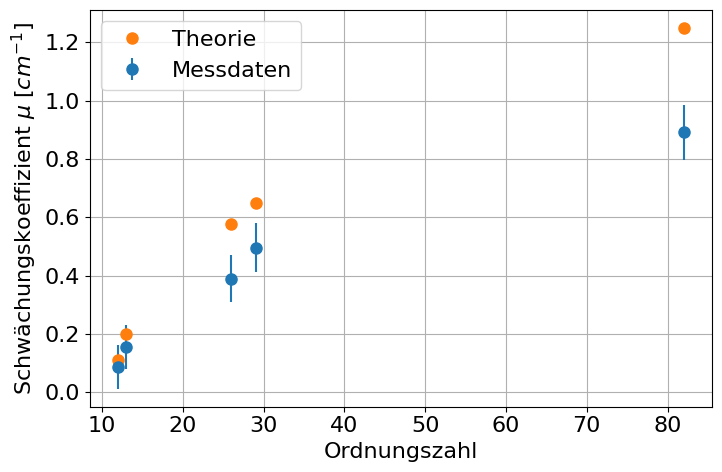

In [13]:
mat_list = ['1_7_al', '1_7_cu','1_7_fe', '1_7_pb', '1_7_pvc', '1_7_empty']
meas_time = np.array([60683, 62161, 63556, 60568, 59310, 60241])*1e-3
Z = np.array([13, 29, 26, 82, 11.998])
density = np.array([2.6989, 8.96, 7.874, 11.342, 1.4])
width = calibrate(0.01, cal_slope , 0)
fit_window = (bins>550) & (bins<700)
integrals = []
for i,file in enumerate(mat_list):    
    b,c = loadhist(file)
    b = calibrate(b)
    popt, pcov = curve_fit(gauss, bins[fit_window], c[fit_window], p0=[100, 600, 50], sigma=np.sqrt(c[fit_window]), absolute_sigma=True)
    integral = np.sum(c[(bins>=popt[1]-np.abs(popt[2])) & (bins<=popt[1]+np.abs(popt[2]))])
    integrals.append(integral)
integrals = np.array(integrals)
rate = integrals/meas_time
rate_empty = rate[-1]
rate = rate[:-1]
mu = -np.log(rate/rate_empty)
err_mu = np.sqrt(1/rate + 1/rate_empty)
mu_th = np.array([7.466E-02, 7.259E-02, 7.346E-02, 1.101E-01, 7.935E-02]) * density # From NIST
fig, ax  = plt.subplots(figsize=(7.5,5))
ax.errorbar(Z, mu, err_mu, None, 'o', label='Messdaten')
ax.plot(Z, mu_th, 'o', label='Theorie')
ax.set(xlabel='Ordnungszahl', ylabel='Schwächungskoeffizient $\mu$ [$cm^{-1}$]')
ax.grid()
ax.legend()
fig.tight_layout()
plt.savefig('plots/sz_z_dependency.pdf', bbox_inches='tight')